In [1]:
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shutil
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

In [45]:
def plot_err(x_input, results, labels, xylabels, title=None, path=None, plottype=None):
    with PdfPages(f'{path}/{title.replace(" ", "_")}.pdf') as pdf:
        for i, (xaxis, result, label) in enumerate(zip(x_input, results, labels)):
            if plottype=='semilogx':
                plt.semilogx(xaxis, result, label=label, color=f'C{i}')
            elif plottype=='semilogy': 
                plt.semilogy(xaxis, result, label=label, color=f'C{i}')
            elif plottype=='loglog': 
                plt.loglog(xaxis, result, label=label, color=f'C{i}')
            else:
                if i==0:
                    plt.scatter(xaxis, result, label=label, s=100, color=f'C{i}', marker=r'$\clubsuit$')
                elif i>0:
                    index = np.argsort(xaxis).astype(int)
                    xaxis = [ xaxis[i] for i in index ]
                    result = [ result[i] for i in index ]
                    # print(f'index={index}')
                    plt.plot(xaxis, result, label=label, color=f'C{i}', marker='.')
                else:
                    plt.plot(xaxis, result, label=label, color=f'C{i}', marker='.')
        # if title:
        #     plt.title(title)
        plt.xlabel(xylabels[0])
        plt.ylabel(xylabels[1])
        plt.legend()
        plt.grid()
        if path:
            pdf.savefig()
        plt.show()

In [15]:
def extract_curve(file_path):
    file_target = open(file_path, 'r')
    perfs, fairs = np.empty([0]), np.empty([0])
    for i, line in enumerate(file_target):
        ls = line.strip('\n')
        if "test acc" in ls:
            acc = re.findall(r"test acc:(.*?)[,$]", ls)
            acc = np.float_(acc)
            perf = acc
            perfs = np.concatenate((perfs, perf))

            # D_SP = np.float_(re.findall(r"DP test:(.*)", ls)[0])
            D_SP = re.findall(r"DP test:(.*)", ls)
            fair = np.float_(D_SP)
            fairs = np.concatenate((fairs, fair))
        elif "test mae" in ls:
            acc = re.findall(r"test mae:(.*?)[,$]", ls)
            acc = np.float_(acc)
            perf = acc
            perfs = np.concatenate((perfs, perf))

            # D_SP = np.float_(re.findall(r"DP test:(.*)", ls)[0])
            D_SP = re.findall(r"DP test:(.*)", ls)
            fair = np.float_(D_SP)
            fairs = np.concatenate((fairs, fair))
        elif "Average of performance and fairness metric:" in ls:
            break
    return perfs, fairs

def extract_perf(file_path):
    file_target = open(file_path, 'r')
    for i, line in enumerate(file_target):
        ls = line.strip('\n')
        if "Test statistics" in ls:
            if "acc" in ls:
                acc = re.findall(r"test acc:(.*)", ls)[0]
                acc = np.float_(acc.split('+-'))
                perf = acc
            elif "mae" in ls:
                acc = re.findall(r"test mae:(.*)", ls)[0]
                acc = np.float_(acc.split('+-'))
                perf = acc
            elif "D_SP" in ls:
                D_SP = re.findall(r"test D_SP:(.*)", ls)[0]
                D_SP = np.float_(D_SP.split('+-'))
                fair = D_SP
    return perf, fair

In [4]:
file_path = f'./log/adult/kernel/-hyper=0.0-4.log'
perf, fair = extract_perf(file_path)
perf 

array([0.825, 0.001])

In [5]:
perf, fair = extract_curve(file_path)
fair

array([0.0096, 0.0117, 0.0137, 0.0155, 0.0173, 0.0188, 0.0203, 0.0216,
       0.0228, 0.0239, 0.0249, 0.0257, 0.0265, 0.0271, 0.0277, 0.0283,
       0.0287, 0.0292, 0.0295, 0.0299, 0.0302, 0.0305, 0.0307, 0.031 ,
       0.0312, 0.0314, 0.0316, 0.0318, 0.0319, 0.0321, 0.0323, 0.0324,
       0.0325, 0.0327, 0.0328, 0.0329, 0.033 , 0.0331, 0.0332, 0.0333,
       0.0334, 0.0335, 0.0335, 0.0336, 0.0337, 0.0337, 0.0338, 0.0338,
       0.0339, 0.0339, 0.034 , 0.034 , 0.0341, 0.0341, 0.0342, 0.0342,
       0.0343, 0.0343, 0.0343, 0.0344, 0.0344, 0.0344, 0.0344, 0.0345,
       0.0345, 0.0345, 0.0345, 0.0345, 0.0346, 0.0346, 0.0346, 0.0346,
       0.0346, 0.0347, 0.0347, 0.0347, 0.0348, 0.0348, 0.0348, 0.0348,
       0.0348, 0.0348, 0.0348, 0.0348, 0.0349, 0.0349, 0.0349, 0.0349,
       0.0349, 0.0349, 0.0349, 0.035 , 0.0349, 0.035 , 0.035 , 0.035 ,
       0.035 , 0.0351, 0.035 , 0.0351, 0.0351, 0.0351, 0.0351, 0.0351,
       0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0352,
      

In [46]:
def results_extract(method, dataset, alpha_vec=None, running_times=5):
    perfs, fairs = np.empty([0,2]), np.empty([0, 2])

    methods = ["kernel", "kernel_bn", "adv", "adv_bn"]
    
    if method in methods:
        index = methods.index(method)
        alphas = alpha_vec[index]
        for alpha in alphas:
            file_path = f'./log/{dataset}/{method}/-hyper={alpha}-{running_times-1}.log'
            
            perf, fair = extract_perf(file_path)
            
            perfs = np.concatenate((perfs, np.expand_dims(perf, 0)))
            fairs = np.concatenate((fairs, np.expand_dims(fair, 0)))

    return perfs, fairs

In [47]:
def results_all(methods, dataset, alpha_vec=None, running_times=5):
    perfs, fairs = [], []
    for method in methods:
        perf, fair = results_extract(method, dataset, alpha_vec, running_times)
        perf, fair = list(perf[:,0]), list(fair[:,0])
        if method=="kernel":
            perfs.append(perf[0:1])
            fairs.append(fair[0:1])

        perfs.append(perf[1:-1])
        fairs.append(fair[1:-1])
    ### return len(methods) + 1
    return perfs, fairs

In [62]:
def plot_tradeoff(method_vec, dataset, alpha_vec, xylabels):
    perfs, fairs = results_all(method_vec, dataset, alpha_vec)

    xaxis = fairs
    results = perfs
    labels = ['vanilla', 'kernel', 'kernel_bn', 'adv', 'adv_bn']
    # xylabels = ['DP', 'MAE']
    title = f'{dataset}_tradeoff'
    path = 'results'

    plot_err(xaxis, results, labels, xylabels, title, path)

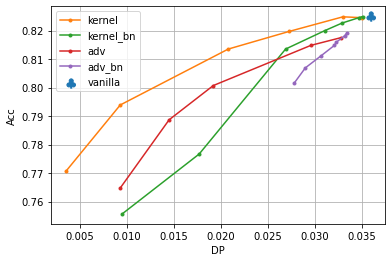

In [204]:
dataset = 'adult'  ## 'adult' 'crimes'
xylabels = ['DP', 'Acc']
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 0.3, 1.0, 3.0, 5.0, 10.0, 20.0, 500.0],
            [0.0, 0.7, 1.0, 3.0, 5.0, 10.0, 20.0, 30.0, 50.0],
            [0.0, 0.7, 10.0, 50.0, 100.0, 500.0, 1000.0],
            [0.0, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, dataset, alpha_vec, xylabels)

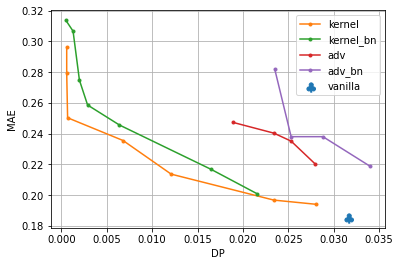

In [205]:
dataset = 'crimes'  ## 'adult' 'crimes'
xylabels = ['DP', 'MAE']
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 0.1, 0.3, 0.7, 1.0, 5.0, 10.0, 20.0, 50.0],
            [0.0, 0.3, 0.5, 1.0, 3.0, 5.0, 50.0, 100.0, 500.0],
            [0.0, 1.0, 5.0, 10.0, 100.0, 500.0],
            [0.0, 1.0, 10.0, 50.0, 500.0, 1000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, dataset, alpha_vec, xylabels)